In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from dowhy import gcm
from sklearn.linear_model import LinearRegression
from econml.dml import LinearDML

# Set colours for plots
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

In [3]:
def plot_graph(input_graph, node_lookup):
    '''
    Function to visualise graphs.

    Args:
        input_graph (array): Adjacency matrix representing graph
        node_lookup (dict): Dictionary containing node names.
    '''
    
    graph = nx.DiGraph(input_graph)

    plt.figure(figsize=(7, 7))
    nx.draw(
    G=graph,
    node_color=COLORS[0],
    node_size=7000,
    arrowsize=17,
    with_labels=True,
    labels=node_lookup,
    font_color='white',
    font_size=9,
    pos=nx.circular_layout(graph)
    )

In [10]:
def data_generator(node_lookup, population, observations, include):
    '''
    A data generating function which has the flexibility to delete nodes - Comparisons of including vs deleting a selected node enables us to calculate ground truth counterfactuals.

    Args:
        node_lookup (dict): Dictionary containing node names.
        population (int): The population size to use when generating the root nodes.
        observations (int): The number of observations to create in the data.
        include (array): Array which indicates whether to include each node (corresponding to the node_lookup). 1 = include / 0 = delete.

    Returns:
        DataFrame: Dataframe containing the generated data.
    '''
    
    df = pd.DataFrame(columns=node_lookup.values())
    df[node_lookup[0]] = (population * np.random.uniform(0.90, 0.95, observations)) * include[0]
    df[node_lookup[1]] = ((0.25 * df[node_lookup[0]]) + (population * np.random.uniform(0.20, 0.30, observations))) * include[1]
    df[node_lookup[2]] = (0.25 * df[node_lookup[0]]) + (0.75 * df[node_lookup[1]])
    
    return df

In [5]:
def counterfactual_impact(target_value_act, target_value_cf):
    '''
    Given an actual and counterfactual target value, calculate the percentage change.

    Args:
        target_value_act (series): Series containing the actual target value.
        target_value_cf (series): Series containing the counterfactual target value.

    Returns:
        float: The counterfactual percentage change to the target value.
    '''
    
    target_change_perc = round((target_value_act.sum() - target_value_cf.sum()) / target_value_act.sum(), 2)
    
    return target_change_perc

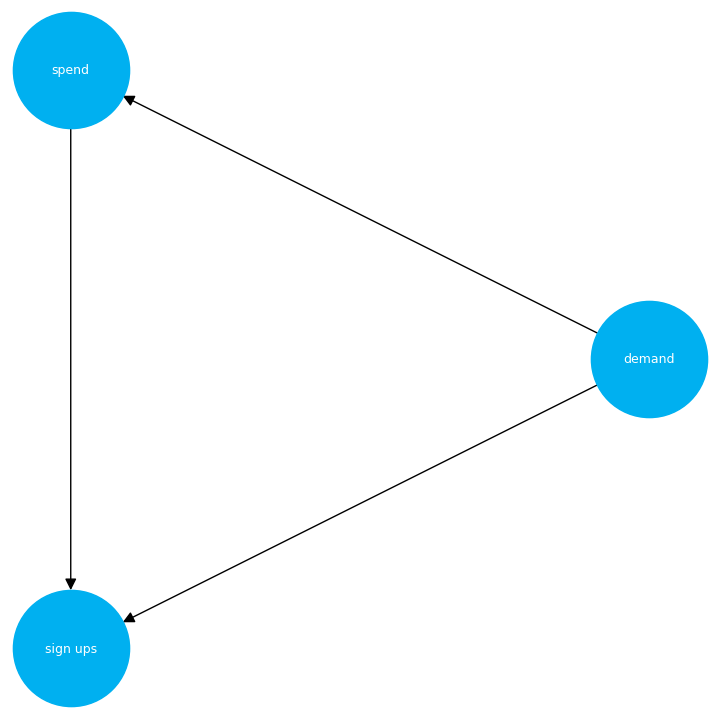

In [11]:
# Create node lookup for channels
node_lookup = {0: 'demand',
    1: 'spend',                
    2: 'sign ups'                                                                             
 }

total_nodes = len(node_lookup)

# Create adjacency matrix - this is the basis for our known graph
graph_actual = np.zeros((total_nodes, total_nodes))

# Create known graph using expert domain knowledge
graph_actual[0, 1] = 1.0 # demand -> spend
graph_actual[0, 2] = 1.0 # demand -> signups
graph_actual[1, 2] = 1.0 # spend -> signups

plot_graph(input_graph=graph_actual, node_lookup=node_lookup)

In [37]:
# Set random seed
np.random.seed(999)

# Generate data
df_original = data_generator(node_lookup=node_lookup, population=10000, observations=365, include=[1, 1])
df_del_demand = data_generator(node_lookup=node_lookup, population=10000, observations=365, include=[0, 1])
df_del_spend = data_generator(node_lookup=node_lookup, population=10000, observations=365, include=[1, 0])

In [38]:
counterfactual_impact(target_value_act=df_original['sign ups'], target_value_cf=df_del_demand['sign ups'])

In [39]:
counterfactual_impact(target_value_act=df_original['sign ups'], target_value_cf=df_del_spend['sign ups'])

In [21]:
# Linear regression
y = df_original['sign ups'].copy()
X = df_original[['demand', 'spend']].copy()
lin_model = LinearRegression()
lin_model = lin_model.fit(X, y)
y_pred = lin_model.predict(X)

# Printing the coefficients
print(f'Intercept: {round(lin_model.intercept_, 4)}')
print(f'Coefficient: {lin_model.coef_}')

Intercept: 0.0
Coefficient: [0.25 0.75]


In [22]:
round((df_original['demand'].sum() * lin_model.coef_[0]) / df_original['sign ups'].sum(), 2)

In [23]:
round((df_original['spend'].sum() * lin_model.coef_[1]) / df_original['sign ups'].sum(), 2)

In [25]:
# DML
y = df_original['sign ups']
T = df_original[['spend']]
X = df_original[['demand']]

est = LinearDML()
est.fit(y, T, X=X, W=None)

In [26]:
round((df_original['spend'].sum() * est.ate(X)) / df_original['sign ups'].sum(), 2)